# Analyze IGF2BP2 RIP in circles
- iteration 6: only 1 replicate
- iteration 10: 3 replicates

# Basic Statistics

In [1]:
import os
from pybedtools import BedTool
import pandas as pd
import seaborn as sns
from plot_params import *
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import precision_recall_curve
from matplotlib_venn import venn2


indir1 = '/home/hsher/scratch/circ_nextera_iter6/output/'
circ_quant_output = [os.path.join(indir1,f) for f in os.listdir(indir1) if f.endswith('.gtf')]

# the basic rar11 recipe
indir = '/home/hsher/scratch/circ_nextera_iter2/output/'
circ_quant_output += [os.path.join(indir,f) for f in os.listdir(indir) if f.endswith('.gtf') 
                      and f.startswith('HEK_rar11')]

indir2 = '/home/hsher/scratch/circ_nextera_iter10/output/'
circ_quant_output += [os.path.join(indir2,f) for f in os.listdir(indir2) if f.endswith('.gtf')]


In [2]:
def read_ciri_gtf(fname):
    bed = BedTool(fname)
    df = bed.to_dataframe()
    # filter for non-entries
    stat = df.loc[df['seqname'].str.contains('##'), 'seqname'].str.split(': ', expand = True)
    df = df.loc[~df['seqname'].str.contains('##')].reset_index()
    
    # get attributes
    attrs = pd.DataFrame([i.attrs for i in bed])
    
    return pd.concat([df, attrs], axis = 1), stat

In [3]:
circ_type_count = []
names = []
junc_ratio_tbl = []
bsj_ratio_tbl = []
fsj_ratio_tbl = []
stats = []
mega_anno = []

features = ['seqname', 'start', 'end', 
       'strand', 'circ_type', 'gene_id', 'gene_name', 'gene_type']
for fname in circ_quant_output:
    
    
    name = os.path.basename(fname).replace('.gtf', '')
    
    names.append(name)

    circ_df, stat = read_ciri_gtf(fname)

    circ_type_count.append(circ_df['circ_type'].value_counts())

    junc_ratio_tbl.append(circ_df.set_index('circ_id')['junc_ratio'].astype(float))
    bsj_ratio_tbl.append(circ_df.set_index('circ_id')['bsj'].astype(float))
    fsj_ratio_tbl.append(circ_df.set_index('circ_id')['fsj'].astype(float))
    stats.append(stat.set_index(0))




    mega_anno.append(circ_df.set_index('circ_id')[features])
mega_anno = pd.concat(mega_anno, axis = 0).drop_duplicates()

stats_df = pd.concat(stats, axis = 1).T
for col in ['##Total_Reads', '##Mapped_Reads', '##Circular_Reads']:
    stats_df[col] = stats_df[col].astype(int)

stats_df = stats_df.drop_duplicates('##Sample').set_index('##Sample')
stats_df['frac_circular'] = stats_df['##Circular_Reads']/stats_df['##Mapped_Reads']
stats_df['frac_mapped'] = stats_df['##Mapped_Reads']/stats_df['##Total_Reads']


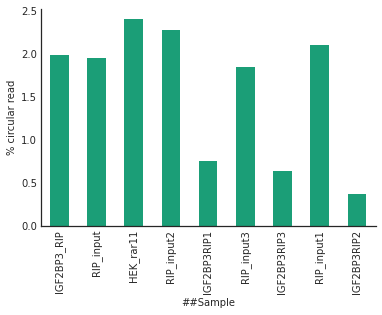

In [4]:

(stats_df['frac_circular']*100).plot.bar()
plt.ylabel('% circular read')
sns.despine()

In [5]:
counts = pd.concat(circ_type_count, axis = 1)
counts.columns = names

In [6]:
bsj = pd.concat(bsj_ratio_tbl, axis = 1)
bsj.columns = names

In [7]:
fsj = pd.concat(fsj_ratio_tbl, axis = 1)
fsj.columns = names

In [8]:
junc = pd.concat(junc_ratio_tbl, axis = 1)
junc.columns = names

In [9]:
bsj_cpm=bsj.div(stats_df['##Total_Reads'], axis = 1)*10**6
fsj_cpm=fsj.div(stats_df['##Total_Reads'], axis = 1)*10**6

# Types of circular RNA detected

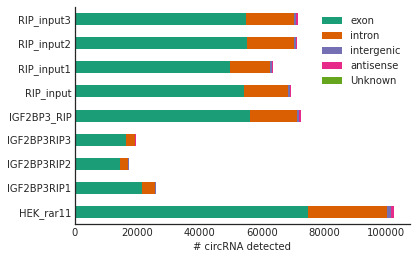

In [10]:
counts.T.sort_index().plot.barh(stacked = True)
plt.xlabel('# circRNA detected')
sns.despine()

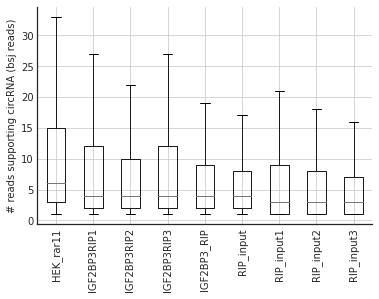

In [11]:
bsj.reindex(sorted(bsj.columns), axis=1).boxplot(showfliers=False, rot = 90)
plt.ylabel('# reads supporting circRNA (bsj reads)')
sns.despine()

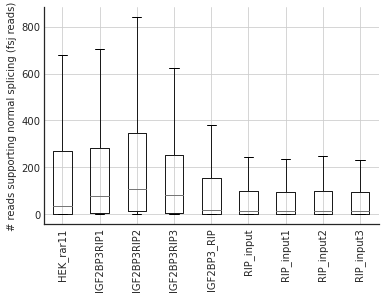

In [12]:
fsj.reindex(sorted(fsj.columns), axis=1).boxplot(showfliers=False, rot = 90)
plt.ylabel('# reads supporting normal splicing (fsj reads)')
sns.despine()

Text(0, 0.5, '(BSJ+1)/(FSJ+1)')

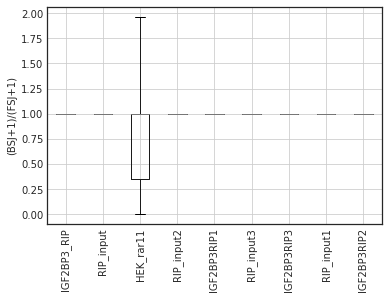

In [13]:
((bsj.fillna(0)+1)/(fsj.fillna(0)+1)).boxplot(showfliers=False, rot = 90)
plt.ylabel('(BSJ+1)/(FSJ+1)')

Text(0.5, 0.98, 'Batch 1')

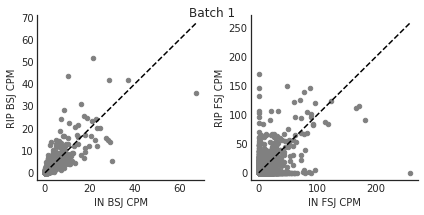

In [14]:
f, axes = plt.subplots(1,2, figsize = (6,3))

for arr, rtype, ax in zip([bsj_cpm, fsj_cpm], ['BSJ','FSJ'], axes.flatten()):
    arr.plot.scatter(x = 'RIP_input', y = 'IGF2BP3_RIP', ax = ax, color = 'grey')
    ax.set_xlabel(f'IN {rtype} CPM')
    ax.set_ylabel(f'RIP {rtype} CPM')
    ax.plot([0,max(arr['RIP_input'].max(),arr['IGF2BP3_RIP'].max())],
              [0,max(arr['RIP_input'].max(),arr['IGF2BP3_RIP'].max())],
               '--', color = 'black'
              )
plt.tight_layout()
sns.despine()
plt.suptitle('Batch 1')


In [15]:
bsj_cpm.columns

Index(['IGF2BP3_RIP', 'RIP_input', 'HEK_rar11', 'RIP_input2', 'IGF2BP3RIP1',
       'RIP_input3', 'IGF2BP3RIP3', 'RIP_input1', 'IGF2BP3RIP2'],
      dtype='object')

Text(0.5, 0.98, 'Batch 2(2023-09)')

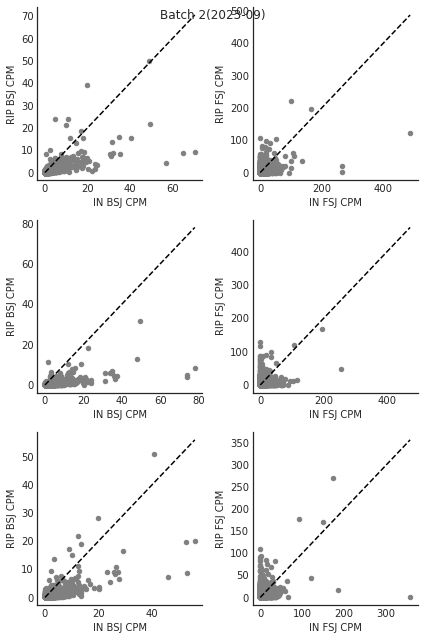

In [16]:
f, axes = plt.subplots(3,2, figsize = (6,9))
for i, rep in enumerate([1,2,3]):
    for j, (arr, rtype)  in enumerate(zip([bsj_cpm, fsj_cpm], ['BSJ','FSJ'])):
        ax = axes[i,j]
        x = f'RIP_input{rep}'
        y = f'IGF2BP3RIP{rep}'
        arr.plot.scatter(x = x, y = y, ax = ax, color = 'grey')
        ax.set_xlabel(f'IN {rtype} CPM')
        ax.set_ylabel(f'RIP {rtype} CPM')
        ax.plot([0,max(arr[x].max(),arr[y].max())],
                  [0,max(arr[x].max(),arr[y].max())],
                   '--', color = 'black'
                  )
plt.tight_layout()
sns.despine()
plt.suptitle('Batch 2(2023-09)')

## correlate between the two batch

Text(0.5, 0.98, 'Comparing batch 1 to batch 2 (input)')

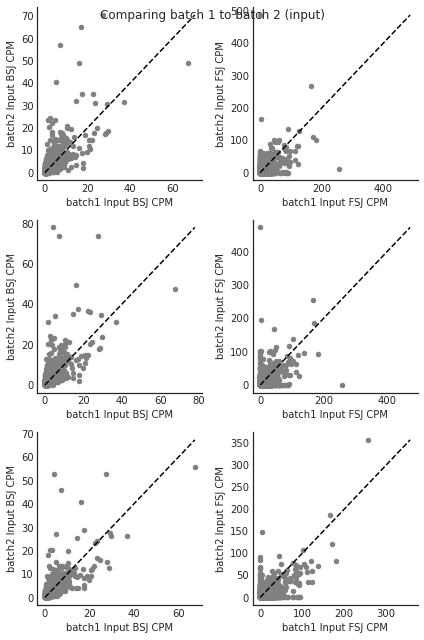

In [17]:
f, axes = plt.subplots(3,2, figsize = (6,9))
for i, rep in enumerate([1,2,3]):
    for j, (arr, rtype)  in enumerate(zip([bsj_cpm, fsj_cpm], ['BSJ','FSJ'])):
        ax = axes[i,j]
        x = f'RIP_input' # first rep
        y = f'RIP_input{rep}'
        arr.plot.scatter(x = x, y = y, ax = ax, color = 'grey')
        ax.set_xlabel(f'batch1 Input {rtype} CPM')
        ax.set_ylabel(f'batch2 Input {rtype} CPM')
        ax.plot([0,max(arr[x].max(),arr[y].max())],
                  [0,max(arr[x].max(),arr[y].max())],
                   '--', color = 'black'
                  )
plt.tight_layout()
sns.despine()
plt.suptitle('Comparing batch 1 to batch 2 (input)')

Text(0.5, 0.98, 'Comparing batch 1 to batch 2')

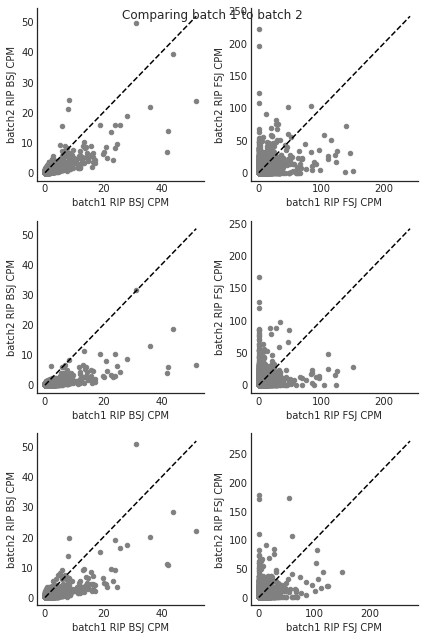

In [18]:
f, axes = plt.subplots(3,2, figsize = (6,9))
for i, rep in enumerate([1,2,3]):
    for j, (arr, rtype)  in enumerate(zip([bsj_cpm, fsj_cpm], ['BSJ','FSJ'])):
        ax = axes[i,j]
        x = f'IGF2BP3_RIP' # first rep
        y = f'IGF2BP3RIP{rep}'
        arr.plot.scatter(x = x, y = y, ax = ax, color = 'grey')
        ax.set_xlabel(f'batch1 RIP {rtype} CPM')
        ax.set_ylabel(f'batch2 RIP {rtype} CPM')
        ax.plot([0,max(arr[x].max(),arr[y].max())],
                  [0,max(arr[x].max(),arr[y].max())],
                   '--', color = 'black'
                  )
plt.tight_layout()
sns.despine()
plt.suptitle('Comparing batch 1 to batch 2')

Text(0.5, 0.98, 'Comparing batch 1 to batch 2')

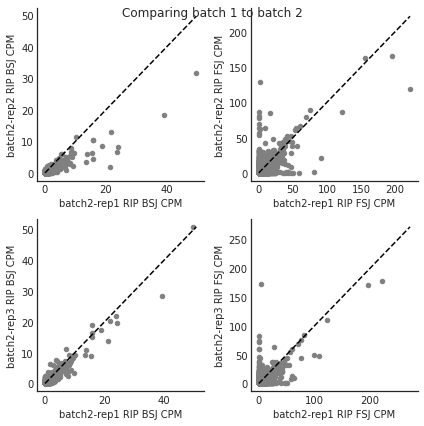

In [19]:
f, axes = plt.subplots(2,2, figsize = (6,6))
for i, rep in enumerate([2,3]):
    for j, (arr, rtype)  in enumerate(zip([bsj_cpm, fsj_cpm], ['BSJ','FSJ'])):
        ax = axes[i,j]
        x = f'IGF2BP3RIP1' # first rep
        y = f'IGF2BP3RIP{rep}'
        arr.plot.scatter(x = x, y = y, ax = ax, color = 'grey')
        ax.set_xlabel(f'batch2-rep1 RIP {rtype} CPM')
        ax.set_ylabel(f'batch2-rep{rep} RIP {rtype} CPM')
        ax.plot([0,max(arr[x].max(),arr[y].max())],
                  [0,max(arr[x].max(),arr[y].max())],
                   '--', color = 'black'
                  )
plt.tight_layout()
sns.despine()
plt.suptitle('Comparing batch 1 to batch 2')

In [20]:
# # convert file format
# circ_df, stat = read_ciri_gtf('/home/hsher/scratch/circ_nextera_iter6/output/IGF2BP3_RIP.gtf')
# for c in ['bsj', 'start', 'end']:
#     circ_df[c] = circ_df[c].astype(float).astype(int)
# circ_df[['seqname', 'start', 'end', 'bsj']].to_csv('/home/hsher/scratch/circ_nextera_iter6/output/IGF2BP3_RIP.circ', 
#                                                    sep = '\t', header = None, index = None)

# circ_df, stat = read_ciri_gtf('/home/hsher/scratch/circ_nextera_iter6/output/RIP_input.gtf')
# for c in ['bsj', 'start', 'end']:
#     circ_df[c] = circ_df[c].astype(float).astype(int)
# circ_df[['seqname', 'start', 'end', 'bsj']].to_csv('/home/hsher/scratch/circ_nextera_iter6/output/RIP_input.circ', 
#                                                    sep = '\t', header = None, index = None)

# CircRIP output

In [21]:
def read_circRIP_outputs(indir, sample1, sample2):
    rip_output = pd.read_csv(Path(indir)/'circRIP/'/f'{sample1}_vs_{sample2}',
    sep = '\t', names = ['circ_id', 'gene', 'BSJs in IP',
            'circRNA in Input','CPM in IP','CPM in Input',
            'IP/Input ratio','p-value', 'status'],
                comment = '>'
            )
    # annotation
    circ_df, stat = read_ciri_gtf(Path(indir)/f'{sample1}.gtf')
    rip_output = rip_output.merge(circ_df, left_on = 'circ_id', right_on = 'circ_id')
    return rip_output

In [22]:
rip_output = read_circRIP_outputs(indir1, 'IGF2BP3_RIP', 'RIP_input')
rip_output2_1 = read_circRIP_outputs(indir2, 'IGF2BP3RIP1', 'RIP_input1')
rip_output2_2 = read_circRIP_outputs(indir2, 'IGF2BP3RIP2', 'RIP_input2')
rip_output2_3 = read_circRIP_outputs(indir2, 'IGF2BP3RIP3', 'RIP_input3')

In [23]:
all_rip_outputs = [rip_output, rip_output2_1, rip_output2_2, rip_output2_3]

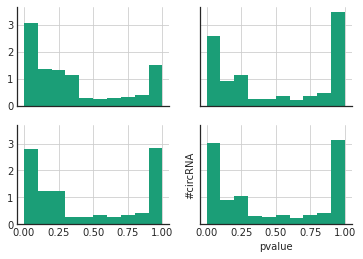

In [24]:
f, ax = plt.subplots(2,2, sharex = True, sharey = True)

rip_output['p-value'].hist(ax = ax[0,0], density = True)
rip_output2_1['p-value'].hist(ax = ax[1,0], density = True)
rip_output2_2['p-value'].hist(ax = ax[0,1], density = True)
rip_output2_3['p-value'].hist(ax = ax[1,1], density = True)
plt.xlabel('pvalue')
plt.ylabel('#circRNA')
sns.despine()

Text(0, 0.5, '# circular RNA')

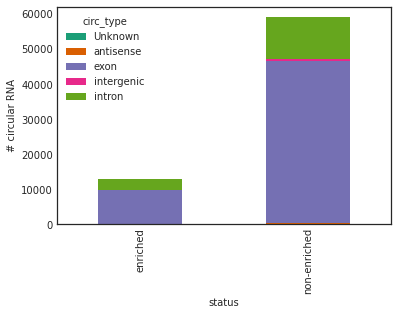

In [25]:
cnt = rip_output.groupby(by = ['circ_type', 'status']).count()['circ_id'].unstack()
cnt.T.plot.bar(stacked = True)
plt.ylabel('# circular RNA')

<AxesSubplot: ylabel='circ_type'>

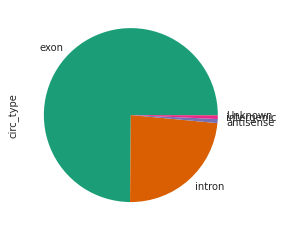

In [26]:
rip_output.loc[rip_output['status']=='enriched', 'circ_type'].value_counts().plot.pie()

## compare to published results

In [27]:
# their circular RNA coordinate is start +1
def transform_circular_rna_id(id_):
    chrom, startend = id_.split(':')
    start, end = startend.split('|')
    start = int(start)+1
    return chrom + ':' + str(start)+'|'+end

published = pd.read_excel('table_s1_bbac186.xls', skiprows = 1)
published['circ_id']=published['CircRNA ID'].apply(transform_circular_rna_id)

0.4212320949609085


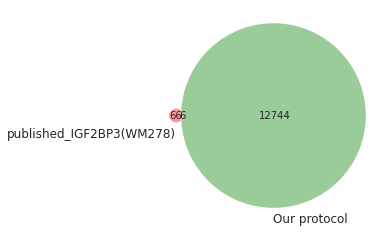

0.5486549925484352


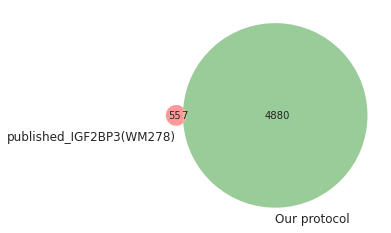

0.3024757461697503


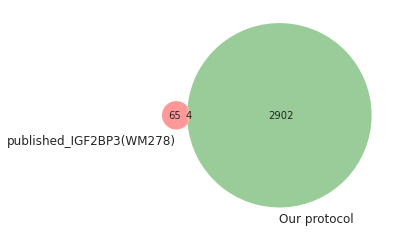

0.12869415735869055


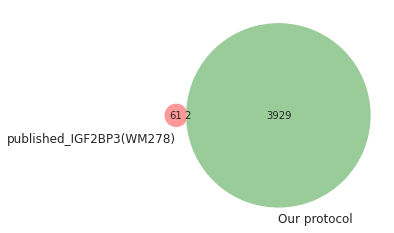

In [28]:
for output in all_rip_outputs:
    output['is_published']=output['circ_id'].isin(published['circ_id'])
    pivot_table = output.groupby(by = ['is_published', 'status']).count()['circ_id'].unstack()
    odds_ratio = (pivot_table.loc[True, 'enriched']/pivot_table.loc[True, 'non-enriched']
                 )/(pivot_table.loc[False, 'enriched']/pivot_table.loc[False, 'non-enriched'])
    
    print(odds_ratio)
    
    venn2([set(output.loc[output['is_published'], 'circ_id']),
           set(output.loc[output['status']=='enriched', 'circ_id'])
          ],set_labels = ['published_IGF2BP3(WM278)', 'Our protocol'])
    plt.show()

# My outputs

In [29]:
from matplotlib_venn import venn3

In [30]:
annot2 = pd.read_csv(Path(indir2)/'count_table.tsv', sep = '\t', index_col = 0)
my_rip_1 = pd.read_csv(Path(indir2) /'RIP/IGF2BP3RIP1.RIP_input1.csv', index_col = 0)
my_rip_2 = pd.read_csv(Path(indir2) /'RIP/IGF2BP3RIP2.RIP_input2.csv', index_col = 0)
my_rip_3 = pd.read_csv(Path(indir2) /'RIP/IGF2BP3RIP3.RIP_input3.csv', index_col = 0)

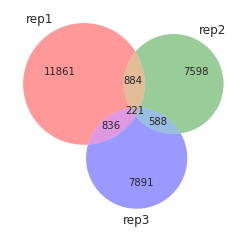

In [31]:
FDR_threshold = 0.2

venn3([set(my_rip_1.loc[my_rip_1['FDR']<FDR_threshold, 'circ_id']),
       set(my_rip_2.loc[my_rip_2['FDR']<FDR_threshold, 'circ_id']),
       set(my_rip_3.loc[my_rip_3['FDR']<FDR_threshold, 'circ_id'])
           
          ],set_labels = ['rep1', 'rep2', 'rep3'])

plt.savefig(figdir/'7_IGF2BP2_RIP_venn.pdf')

In [32]:
three_reps = set(my_rip_1.loc[my_rip_1['FDR']<FDR_threshold, 'circ_id']).intersection(
       set(my_rip_2.loc[my_rip_2['FDR']<FDR_threshold, 'circ_id'])).intersection(
       set(my_rip_3.loc[my_rip_3['FDR']<FDR_threshold, 'circ_id']))

## Compare with published results

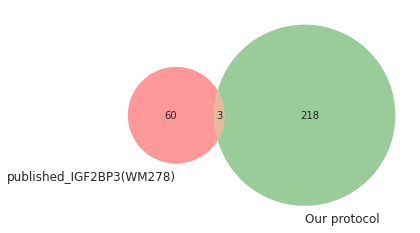

In [33]:
venn2([set(output.loc[output['is_published'], 'circ_id']),
           three_reps
          ],set_labels = ['published_IGF2BP3(WM278)', 'Our protocol'])
plt.savefig(figdir/'7_IGF2BP2_overlap_published.pdf')

In [34]:
circ_bed_df = annot2[ 
           ['seqname', 'start', 'end', 'circ_id', 'circ_type', 'strand']
          ]
circ_bed_df['start'] = circ_bed_df['start'].astype(int)
circ_bed_df['end'] = circ_bed_df['end'].astype(int)
circ_bed = BedTool.from_dataframe(circ_bed_df)
eclip = pd.read_csv('/projects/ps-yeolab5/rbp-portal/encode3/eclip/Skipper/bb63a25/encode_v1/output/reproducible_enriched_windows/IGF2BP3_HepG2_ENCSR993OLA.reproducible_enriched_windows.tsv.gz',
                    sep = '\t')
eclip_bed = BedTool.from_dataframe(eclip[['chr', 'start', 'end', 'name', 'score', 'strand']])

annot2['is_eclip'] = annot2['circ_id'].isin(circ_bed.intersect(eclip_bed, s = True, F=0.5).to_dataframe()['name'])
annot2['is_RIP_rep1'] = annot2['circ_id'].isin(
    my_rip_1.loc[my_rip_1['FDR']<FDR_threshold, 'circ_id'])
annot2['is_RIP_rep2'] = annot2['circ_id'].isin(
    my_rip_2.loc[my_rip_2['FDR']<FDR_threshold, 'circ_id'])
annot2['is_RIP_rep3'] = annot2['circ_id'].isin(
    my_rip_3.loc[my_rip_3['FDR']<FDR_threshold, 'circ_id'])
annot2['RIP_reproducible']=(annot2['is_RIP_rep1'])&(annot2['is_RIP_rep2'])&(annot2['is_RIP_rep3'])
annot2['is_published']=annot2['circ_id'].isin(published['circ_id'].tolist())

/scratch/hsher/33883362.tscc-mgr7.local/ipykernel_20837/157624617.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  circ_bed_df['start'] = circ_bed_df['start'].astype(int)
/scratch/hsher/33883362.tscc-mgr7.local/ipykernel_20837/157624617.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  circ_bed_df['end'] = circ_bed_df['end'].astype(int)
***** WARNING: File /scratch/hsher/33883362.tscc-mgr7.local/pybedtools.4cfxei3v.tmp has inconsistent naming convention for record:
GL000195.1	48444	49119	GL000195.1:484

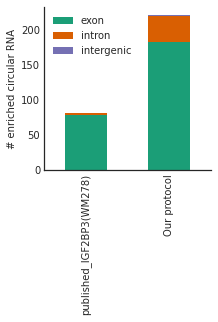

In [35]:
counts_compare = pd.concat([annot2.loc[annot2['is_published'], 'circ_type'].value_counts(),
           annot2.loc[annot2['RIP_reproducible'], 'circ_type'].value_counts()],
         axis = 1)
counts_compare.columns = ['published_IGF2BP3(WM278)', 'Our protocol']
counts_compare.T.plot.bar(stacked = True, figsize = (3,3))
plt.ylabel('# enriched circular RNA')
sns.despine()
plt.savefig(figdir/'7_IGF2BP2_circtype.pdf')

# compare to the transcirc database

In [36]:
transcirc = pd.read_csv('transcirc_metadata.tsv', sep = '\t')
transcirc['circ_id']=transcirc['chrom']+':'+transcirc['start'].astype(str)+'|'+transcirc['end'].astype(str)
transcirc.drop_duplicates(subset = ['circ_id'], inplace = True)

In [37]:
annot2['m6A'] = annot2['circ_id'].map(transcirc.set_index('circ_id')['m6A'].map({1:True, 0:False}))

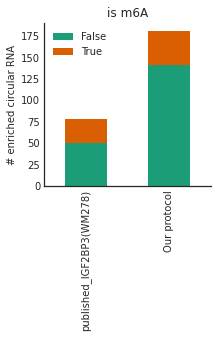

In [38]:
counts_compare = pd.concat([annot2.loc[annot2['is_published'], 'm6A'].value_counts(),
           annot2.loc[annot2['RIP_reproducible'], 'm6A'].value_counts()],
         axis = 1)
counts_compare.columns = ['published_IGF2BP3(WM278)', 'Our protocol']
counts_compare.T.plot.bar(stacked = True, figsize = (3,3))
plt.ylabel('# enriched circular RNA')
plt.title('is m6A')
sns.despine()
plt.savefig(figdir/'7_IGF2BP2_m6A.pdf')

In [39]:
from scipy.stats import fisher_exact,chisquare
def testing(df):
    ''' perform fisher exact or chisq given contingency table'''
    if df.shape != (2,2):
        # some outcomes are unobserved
        print(df.shape)
        print('no binding is observed in')
        return 1, np.nan
    if df.le(5).any().any():
        odds_ratio, pvalue = fisher_exact(df)
    else:
        chi, pvalue = chisquare(df.loc[True], (df.loc[True].sum())*df.loc[False].div(df.loc[False].sum()))
        odds_ratio = (df.loc[True, True]/df.loc[True, False])/(df.loc[False, True]/df.loc[False, False])
    return pvalue, odds_ratio

In [41]:
transcirc['m6A'] = (transcirc['m6A']>0)
transcirc['is_IGF2BP3']=transcirc['circ_id'].isin(three_reps)
testing(transcirc.groupby(by = ['is_IGF2BP3', 'm6A']).count()['circ_id'].unstack())

(2.9267743287679913e-05, 2.0796286114899853)

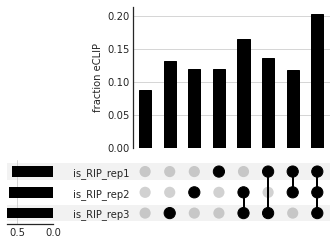

In [43]:
from upsetplot import plot
plot(annot2.groupby(by = [c for c in annot2.columns if c.startswith('is_RIP_')])['is_eclip'].mean(),
    )
plt.ylabel('fraction eCLIP')
plt.savefig(figdir/'7_IGF2BP2_fraction_eclip.pdf')

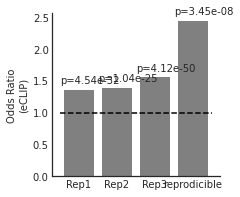

In [52]:
pv_repro, odds_repro = testing(annot2.groupby(by = ['RIP_reproducible', 'is_eclip']).count()['circ_id'].unstack())
pv1, odds1 = testing(annot2.groupby(by = ['is_RIP_rep1', 'is_eclip']).count()['circ_id'].unstack())
pv2, odds2 = testing(annot2.groupby(by = ['is_RIP_rep2', 'is_eclip']).count()['circ_id'].unstack())
pv3, odds3 = testing(annot2.groupby(by = ['is_RIP_rep3', 'is_eclip']).count()['circ_id'].unstack())

f, ax = plt.subplots(1,1, figsize = (3,3))
x = [0,1,2,3]
y = [odds1, odds2, odds3, odds_repro]
ax.bar(x = x, height = y, color = 'grey')
for xi, yi, pvalue in zip(x,y,[pv1, pv2,pv3, pv_repro]):
    plt.text(xi-0.5, yi+0.1, f'p={pvalue:.2e}')

plt.ylabel('Odds Ratio\n(eCLIP)')

plt.xticks(x, ['Rep1', 'Rep2', 'Rep3', 'reprodicible'])
plt.hlines(y = 1, xmin = -0.5, xmax = max(x)+0.5, linestyle = '--', color = 'black')
sns.despine()
plt.savefig(figdir/'7_IGF2BP2_eclipodds.pdf')

In [55]:
# get_circle_fa
from Bio import SeqIO
allfa = {}
for fa in list(Path(indir2).glob('circ/*.fa')):
    

    for record in SeqIO.parse(fa, "fasta"):
        allfa[record.id]=record
len(allfa)


198709

In [59]:
# fetch bound sequence
bound_seqrecord = [allfa[i] for i in annot2.loc[annot2['RIP_reproducible'], 'circ_id'].tolist()]
bound_seqrecord_r1 = [allfa[i] for i in annot2.loc[annot2['is_RIP_rep1'], 'circ_id'].tolist()]
bound_seqrecord_r2 = [allfa[i] for i in annot2.loc[annot2['is_RIP_rep2'], 'circ_id'].tolist()]
bound_seqrecord_r3 = [allfa[i] for i in annot2.loc[annot2['is_RIP_rep3'], 'circ_id'].tolist()]
notbound_seqrecord = [allfa[i] for i in annot2.loc[~annot2[['is_RIP_rep3','is_RIP_rep2','is_RIP_rep1']].any(axis = 1), 'circ_id'].tolist()]

In [60]:
len(bound_seqrecord)

221

In [61]:
len(notbound_seqrecord)

110500

In [63]:
with open(Path(indir)/'IGF2BP3_bound.fa', "w") as output_handle:
    SeqIO.write(bound_seqrecord, output_handle, "fasta")

with open(Path(indir)/'IGF2BP3_notbound.fa', "w") as output_handle:
    SeqIO.write(notbound_seqrecord, output_handle, "fasta")


In [66]:
indir

'/home/hsher/scratch/circ_nextera_iter2/output/'

module load homer
homer2 denovo -i /home/hsher/scratch/circ_nextera_iter2/output/IGF2BP3_bound.fa\
            -b /home/hsher/scratch/circ_nextera_iter2/output/IGF2BP3_notbound.fa \
            -strand + -o /home/hsher/scratch/RIP_homer

In [65]:
indir2

'/home/hsher/scratch/circ_nextera_iter10/output/'

#combine and remove redundancy
awk '/^>/{p=seen[$0]++}!p' /home/hsher/scratch/circ_nextera_iter10/output/circ/*index.fa > /home/hsher/scratch/circ_nextera_iter10/output/circ/all.fa